# 3-1 Accuracy  (정확도)

In [20]:
import numpy as np
from sklearn.base import BaseEstimator


class MyDummyClassifier(BaseEstimator):
    # fit 메소드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # predict() 메소드는 단순히 Sex feature가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [21]:
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Embarked'].fillna('N', inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace = True)
    return df


def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Embarked', 'Sex']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_feature(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df
    

In [22]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv('./train.csv')
y_t_df = titanic_df['Survived']
x_t_df = titanic_df.drop('Survived', axis = 1)
x_t_df = transform_feature(x_t_df)

X_train, X_test, y_train, y_test = train_test_split(x_t_df, y_t_df, \
                                                   test_size = 0.2, random_state = 11)

In [23]:
mclf = MyDummyClassifier()
mclf.fit(X_train, y_train)

mypredictions = mclf.predict(X_test)
print(accuracy_score(y_test, mypredictions))

0.8324022346368715


# 3-2 Confusion Matrix (오차 행렬)

- 정밀도:예측을 positive로 한 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율
- 재현율:실제값이 positive인 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, mypredictions)

array([[103,  15],
       [ 15,  46]])

## 정밀도(precision)와 재현율(recall)

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(precision_score(y_test, mypredictions))
print(recall_score(y_test, mypredictions))

0.7540983606557377
0.7540983606557377


- 오차행렬 정확도 정밀도 재현율을 한꺼번에 계산하는 함수 생성

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))

In [27]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv('./train.csv')
y_t_df = titanic_df['Survived']
X_t_df = titanic_df.drop('Survived', axis = 1)
X_t_df = transform_feature(X_t_df)

X_train, X_test, y_train, y_test = train_test_split(X_t_df, y_t_df,
                                                   test_size = 0.2, random_state = 11)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 3-3Precicion/Recall Trade-off

predict_proba() 메소드 확인

In [28]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print('predict_proba shape:{0}'.format(pred_proba.shape))
print('pred_proba array 에서 앞 3개만 샘플로 추출 \n :', pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

predict_proba shape:(179, 2)
pred_proba array 에서 앞 3개만 샘플로 추출 
 : [[0.46189204 0.53810796]
 [0.87872347 0.12127653]
 [0.87720675 0.12279325]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46189204 0.53810796 1.        ]
 [0.87872347 0.12127653 0.        ]
 [0.87720675 0.12279325 0.        ]]


Binarizer 활용

In [29]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# thresholf 기준값보다 같거나 작으면 0을 , 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환

In [30]:
from sklearn.preprocessing import Binarizer

# Binarizer 의 threshold 설정값, 분류 결정 임곗값임.
custom_threshold = 0.5

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869


In [31]:
from sklearn.preprocessing import Binarizer

# Binarizer 의 threshold 설정값, 분류 결정 임곗값임.
custom_threshold = 0.4

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361


precision_racall_curve() 를 이용하여 임곗값에 따른 정밀도-재현율 값 추출

In [36]:
from sklearn.metrics import precision_recall_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('threshold:', thresholds.shape)
print('precisions:', precisions.shape)
print('recalls:', recalls.shape)
print(thresholds[:5])
print(precisions[:5])
print(recalls[:5])

threshold: (143,)
precisions: (144,)
recalls: (144,)
[0.1038794  0.10388165 0.1039068  0.10782079 0.10885047]
[0.38853503 0.38461538 0.38709677 0.38961039 0.38562092]
[1.         0.98360656 0.98360656 0.98360656 0.96721311]


In [38]:
thr_index = np.arange(0, thresholds.shape[0], 15)
print(np.round(thresholds[thr_index], 2))
print(np.round(precisions[thr_index], 3))
print(np.round(recalls[thr_index], 3))

[0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
[0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
[1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


# 3-4 F1 Score

In [40]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
f1

0.7804878048780488

In [41]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    

# 3-5 ROC Curve와 AUC

In [50]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(0, thresholds.shape[0], 5)

print('샘플 추출을 위한 임곗값 배열의 index 10개', thr_index)
print('샘플용 10개의 임곗값', np.round(thresholds[thr_index], 2))

print('샘플 입곗값 별 FPR', np.round(fprs[thr_index], 3))
print('샘플 임곗값 별 TPR', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개 [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임곗값 [1.97 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
샘플 입곗값 별 FPR [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
샘플 임곗값 별 TPR [0.    0.475 0.689 0.754 0.787 0.836 0.869 0.902 0.918 0.967 0.967]


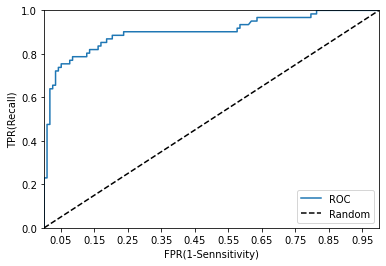

In [54]:
import matplotlib.pyplot as plt
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1], [0,1],'k--', label = 'Random')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Sennsitivity)');plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()


roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [55]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값:{0:.4f}'.format(roc_score))

ROC AUC 값:0.9024
